In [ ]:
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [ ]:
train = pd.read_csv('ta-en-misogyny-train.csv',sep='\t', names = ["category", "text"])
train = train.dropna()

In [ ]:
test = pd.read_csv('ta-en-misogyny-dev.csv',sep='\t', names = ["category", "text"])
test = test.dropna()

In [ ]:
train

,category,text
0,None-of-the-above,enaku unmaikum aluha wantu thirunangaigal thei...
1,Transphobic,SUPERSTAR VIJAY dai arivuketta polu ithu thapp...
2,None-of-the-above,Ugka smile cute a iruku😊😊...
3,None-of-the-above,Anna i am waiting na 🥰🥰🥰
4,None-of-the-above,Yanda tamilnadu la evvalavo pirachana iruku at...
...,...,...
5943,None-of-the-above,Noq day having no caste no religious certificate
5944,None-of-the-above,Mimicry escape aitaru bro. 😂
5945,None-of-the-above,Rajesh R u age u from
5946,Counter-speech,Bro unga videos nallarukku but don't do prank ...


In [ ]:
labels = train.category.unique()
labels

array(['None-of-the-above', 'Transphobic', 'Counter-speech', 'Misandry',
       'Homophobia', 'Hope-Speech', 'Xenophobia', 'Misogyny'],
      dtype=object)

In [ ]:
import string
def removepunctuation(text):
    clean="".join([i for i in text if i not in string.punctuation])
    return clean

import re
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def tolower(text):
  return text.lower()

label = { 'None-of-the-above': 0, 'Transphobic':1, 'Counter-speech':2, 'Misandry':3,
       'Homophobia':4, 'Hope-Speech':5, 'Xenophobia':6, 'Misogyny':7}

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['nalla','ena','unaku','per','irukanga','panna','yarum','mattum','ivan','ada','pesa','unakku','k','sari','idhu','vida','vittu','enga','yen','ithu','poda','dey','irundhu','ya','la', 'u','r','s','bro','da','dei','dai','nu','ah','nee','ni','illa','un','ok','na','pls','ur','unga']) 
stopwords_list.extend(['🥰','indha','antha','vera','iruka','pola','innum','avan','summa','ellam','thaan','❤️','ana','ama','apdi','ithula','po','evlo','eruku','irukum','nama','enna','va','hi','h','ku','iruku','naa','va','oru','athu','avanga','neenga','tha','en','di','dhan','ne','ella','intha']) 

label = { 'None-of-the-above': 0, 'Transphobic':1, 'Counter-speech':2, 'Misandry':3,
       'Homophobia':4, 'Hope-Speech':5, 'Xenophobia':6, 'Misogyny':7}

def removestopwords(text):
  clean = " ".join([word for word in text.split() if word not in stopwords_list])
  return clean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess(df):
  df['text']= df['text'].apply(lambda x:tolower(x))
  df['text']= df['text'].apply(lambda x:removepunctuation(x))
  df['text']= df['text'].apply(lambda x:deEmojify(x))
  df['text']= df['text'].apply(lambda x:removestopwords(x))
  df["category"] = df["category"].map(label)
  return df

In [ ]:
train = preprocess(train)
train

,category,text
0,0,enaku unmaikum aluha wantu thirunangaigal thei...
1,1,superstar vijay arivuketta polu thappu pavam a...
2,0,ugka smile cute
3,0,anna waiting 🥰🥰🥰
4,0,yanda tamilnadu evvalavo pirachana athalam vit...
...,...,...
5943,0,noq day caste religious certificate
5944,0,mimicry escape aitaru
5945,0,rajesh age
5946,2,videos nallarukku dont prank eena varavanga ep...


In [ ]:
test = preprocess(test)

In [ ]:
def tokenize(text):
  return text.split()


train['token']= train['text'].apply(lambda x:tokenize(x))
test['token']= test['text'].apply(lambda x:tokenize(x))

In [ ]:
train

,category,text,token
0,0,enaku unmaikum aluha wantu thirunangaigal thei...,"[enaku, unmaikum, aluha, wantu, thirunangaigal..."
1,1,superstar vijay arivuketta polu thappu pavam a...,"[superstar, vijay, arivuketta, polu, thappu, p..."
2,0,ugka smile cute,"[ugka, smile, cute]"
3,0,anna waiting 🥰🥰🥰,"[anna, waiting, 🥰🥰🥰]"
4,0,yanda tamilnadu evvalavo pirachana athalam vit...,"[yanda, tamilnadu, evvalavo, pirachana, athala..."
...,...,...,...
5943,0,noq day caste religious certificate,"[noq, day, caste, religious, certificate]"
5944,0,mimicry escape aitaru,"[mimicry, escape, aitaru]"
5945,0,rajesh age,"[rajesh, age]"
5946,2,videos nallarukku dont prank eena varavanga ep...,"[videos, nallarukku, dont, prank, eena, varava..."


In [ ]:
train ["len"] = train.text.apply(lambda x : len(x))
test ["len"] = test.text.apply(lambda x : len(x))

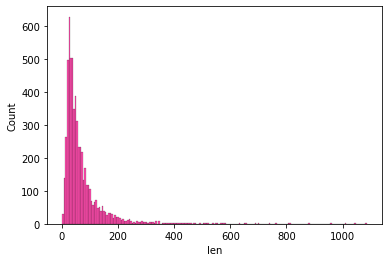

In [ ]:
import seaborn as sns
sns.histplot(train.len, color='deeppink') #huge outliers must be removed

In [ ]:
train.category.loc[train.len<100].value_counts() 

0    3408
3     650
6     221
7     142
5     139
2     109
1     105
4     102
Name: category, dtype: int64

In [ ]:
df = train.loc[train.category.isin([1,2,3,4,5,6,7])].copy()
df

,category,text,token,len
1,1,superstar vijay arivuketta polu thappu pavam a...,"[superstar, vijay, arivuketta, polu, thappu, p...",91
5,1,night fulla mater alaiuradhu day fulla pichaik...,"[night, fulla, mater, alaiuradhu, day, fulla, ...",86
9,2,pradeep kodi maataanga nenaikireengala ellaaru...,"[pradeep, kodi, maataanga, nenaikireengala, el...",189
10,3,yena public pudikalayadei arivu ellathavane at...,"[yena, public, pudikalayadei, arivu, ellathava...",162
12,4,515 paiyyan straight girl friend gay illai ava...,"[515, paiyyan, straight, girl, friend, gay, il...",112
...,...,...,...,...
5934,3,hiphopgamer92 thevdiaaa paiyaaa pottaa amaaa j...,"[hiphopgamer92, thevdiaaa, paiyaaa, pottaa, am...",133
5938,3,mendal epo ponnunga ambala rights thanthangale...,"[mendal, epo, ponnunga, ambala, rights, thanth...",87
5941,3,endha thevidiya payalavairamuthuva thaane solr...,"[endha, thevidiya, payalavairamuthuva, thaane,...",82
5942,7,nadu roomba irunthathu epo ponnunga ambala rig...,"[nadu, roomba, irunthathu, epo, ponnunga, amba...",97


In [ ]:
df = df.append(train[train.category.isin([0])].head(1500))

In [ ]:
df

,category,text,token,len
1,1,superstar vijay arivuketta polu thappu pavam a...,"[superstar, vijay, arivuketta, polu, thappu, p...",91
5,1,night fulla mater alaiuradhu day fulla pichaik...,"[night, fulla, mater, alaiuradhu, day, fulla, ...",86
9,2,pradeep kodi maataanga nenaikireengala ellaaru...,"[pradeep, kodi, maataanga, nenaikireengala, el...",189
10,3,yena public pudikalayadei arivu ellathavane at...,"[yena, public, pudikalayadei, arivu, ellathava...",162
12,4,515 paiyyan straight girl friend gay illai ava...,"[515, paiyyan, straight, girl, friend, gay, il...",112
...,...,...,...,...
2368,0,appe kamam rombe mukkiyama kadhal idame illaiya,"[appe, kamam, rombe, mukkiyama, kadhal, idame,...",47
2369,0,mathiri nanum valanum assai yanaku,"[mathiri, nanum, valanum, assai, yanaku]",34
2370,0,super super speakers,"[super, super, speakers]",20
2371,0,ungal samuthayam peruvariyana non bramin samoo...,"[ungal, samuthayam, peruvariyana, non, bramin,...",125


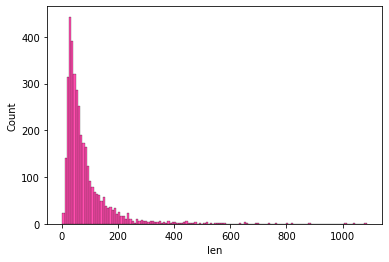

In [ ]:
import seaborn as sns
sns.histplot(df.len, color='deeppink')


In [ ]:
from collections import Counter
x = df.groupby("category")["text"].apply(lambda x: Counter(" ".join(x).split()).most_common(100))
x[7]

[('amma', 19),
 ('appa', 19),
 ('thevidiya', 18),
 ('gh', 16),
 ('wb', 16),
 ('ponnunga', 16),
 ('kooda', 15),
 ('ponnu', 14),
 ('ungomma', 12),
 ('poi', 12),
 ('pundaila', 11),
 ('ponna', 11),
 ('thappu', 10),
 ('vara', 10),
 ('anitha', 10),
 ('payale', 10),
 ('pondati', 10),
 ('pondatti', 9),
 ('pundaya', 9),
 ('kuda', 9),
 ('girls', 8),
 ('mooditu', 8),
 ('thangachi', 8),
 ('porantha', 8),
 ('loosu', 7),
 ('avala', 7),
 ('entha', 7),
 ('pecha', 7),
 ('koodhi', 6),
 ('ombodhu', 6),
 ('pasanga', 6),
 ('pesura', 6),
 ('nenga', 6),
 ('dowry', 6),
 ('serupala', 6),
 ('meera', 6),
 ('inga', 6),
 ('priya', 6),
 ('naye', 6),
 ('ippadi', 6),
 ('kilichi', 6),
 ('maathiri', 6),
 ('kelunga', 6),
 ('ila', 5),
 ('kalyanam', 5),
 ('punda', 5),
 ('marriage', 5),
 ('panra', 5),
 ('podi', 5),
 ('ungaluku', 5),
 ('irukka', 5),
 ('ava', 5),
 ('life', 5),
 ('thana', 5),
 ('dii', 5),
 ('nasama', 5),
 ('ketta', 5),
 ('black', 5),
 ('potta', 5),
 ('iruntha', 5),
 ('sex', 5),
 ('support', 5),
 ('kitta', 5),

In [ ]:
processed = [key for groups in x for key, value in groups]


In [ ]:
uniqueset = set(processed)
processed = list(uniqueset) 

In [ ]:
processed

['ivanga',
 'country',
 'pondatti',
 'thayvidiyaa',
 'tq',
 '100',
 'pathi',
 'veliya',
 'pa',
 'part',
 'vibasaaram',
 'speech',
 'like',
 'vantheri',
 'night',
 'kooti',
 'ali',
 'paiya',
 'oththaa',
 'itha',
 'onnum',
 'vandhu',
 'kuduththu',
 'thappa',
 'alaiuradhu',
 'aan',
 'pera',
 'porandha',
 'thappu',
 'virus',
 'close',
 'natarajan',
 'niga',
 'vada',
 'ketta',
 'pundaila',
 'episode',
 'maathiri',
 'pathu',
 'kadavul',
 'kadhayalla',
 'avana',
 'pon',
 'family',
 'badu',
 'hraja',
 'ivlo',
 'vendum',
 'wb',
 'lam',
 'kalyanam',
 'podanum',
 'sema',
 'potta',
 'சுபா',
 'sex',
 'ulagathula',
 'sila',
 'dowry',
 'vanthu',
 'maari',
 'mari',
 'call',
 'kasu',
 'great',
 'mutta',
 'um',
 'endru',
 'ungal',
 'send',
 'matum',
 'nanba',
 'irukanum',
 'map',
 'irundha',
 'ennoda',
 'thirunangaigal',
 'namma',
 'ippadi',
 'naanthanda',
 'evanga',
 'solli',
 'echa',
 'inga',
 'neraya',
 'bjp',
 'dont',
 'thali',
 'pakistan',
 'panunga',
 'kumar',
 'thevudiya',
 'best',
 'epdi',
 'akk

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
count_vect = CountVectorizer(vocabulary=processed)

In [ ]:
X_train = count_vect.fit_transform(df["text"])

In [ ]:
X_train

<3728x458 sparse matrix of type '<class 'numpy.int64'>'
	with 10444 stored elements in Compressed Sparse Row format>

In [ ]:
y_train = df["category"]

In [ ]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', C=1, verbose=True)
svm_model.fit(X_train, y_train)

[LibSVM]

SVC(C=1, verbose=True)

In [ ]:
X_test = count_vect.fit_transform(test["text"])
y_test = test["category"]

In [ ]:
y_pred = svm_model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       917
           1       0.33      0.07      0.12        40
           2       0.30      0.26      0.28        95
           3       0.64      0.60      0.62       218
           4       0.88      0.16      0.27        43
           5       0.31      0.08      0.12        53
           6       0.93      0.54      0.68        70
           7       0.75      0.06      0.11        50

    accuracy                           0.71      1486
   macro avg       0.61      0.34      0.38      1486
weighted avg       0.69      0.71      0.67      1486



In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81       917
           1       0.22      0.10      0.14        40
           2       0.45      0.19      0.27        95
           3       0.68      0.43      0.52       218
           4       0.62      0.35      0.45        43
           5       0.25      0.17      0.20        53
           6       0.77      0.51      0.62        70
           7       0.50      0.16      0.24        50

    accuracy                           0.69      1486
   macro avg       0.53      0.35      0.41      1486
weighted avg       0.66      0.69      0.65      1486



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',vocabulary=processed)
X_train = tfidfvectorizer.fit_transform(df["text"])
X_test = tfidfvectorizer.fit_transform(test["text"])

In [ ]:
pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('sentence-transformers/LaBSE')
embedding_train = embedding_model.encode(df["text"].tolist())
embedding_train

array([[ 0.03703719, -0.00945071, -0.01874886, ...,  0.0171435 ,
         0.02029732, -0.07182929],
       [-0.0348301 , -0.01214745, -0.00731626, ..., -0.04134737,
         0.01021737,  0.04658515],
       [-0.01826746,  0.0024244 , -0.01131572, ..., -0.03682222,
        -0.00458307, -0.04294987],
       ...,
       [-0.02496426,  0.02431605,  0.00629303, ...,  0.01764581,
        -0.00429279, -0.01858609],
       [ 0.02176867,  0.0338227 , -0.04838873, ..., -0.06648374,
        -0.03640271,  0.00550432],
       [-0.03217659,  0.00644815, -0.04606404, ...,  0.01850251,
        -0.05941031,  0.03389828]], dtype=float32)

In [ ]:
embedding_test = embedding_model.encode(test["text"].tolist())
embedding_test

array([[ 0.01120971, -0.03313995,  0.00473974, ..., -0.0256553 ,
        -0.05266358, -0.05841319],
       [ 0.02672609, -0.0455672 , -0.04249708, ...,  0.04166488,
         0.01122462, -0.02820799],
       [-0.02745358,  0.01689432, -0.01442928, ..., -0.000446  ,
         0.01598727, -0.01762459],
       ...,
       [ 0.00382099,  0.03070443,  0.01528695, ...,  0.00110256,
         0.02784411,  0.0175535 ],
       [ 0.01393002, -0.0561255 , -0.00415159, ..., -0.02894724,
        -0.02773055, -0.0183674 ],
       [ 0.00162178,  0.08250223, -0.00743317, ...,  0.00394696,
        -0.01803309, -0.0089564 ]], dtype=float32)

In [ ]:
Xtrain = [np.append(list1, list2) for list1, list2 in zip(embedding_train, X_train.toarray())]
Xtest = [np.append(list1, list2) for list1, list2 in zip(embedding_test, X_test.toarray())]

In [ ]:
ytrain = df["category"].tolist()
ytest = test["category"].tolist()

In [ ]:
Xtrain

[array([ 0.03703719, -0.00945071, -0.01874886, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.0348301 , -0.01214745, -0.00731626, ...,  0.        ,
         0.23879071,  0.        ]),
 array([-0.01826746,  0.0024244 , -0.01131572, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.00616755,  0.01552273,  0.0408394 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.05845573,  0.00838901, -0.06778771, ...,  0.        ,
         0.        ,  0.        ]),
 array([0.03439618, 0.01595158, 0.03956516, ..., 0.        , 0.        ,
        0.        ]),
 array([-0.02551662,  0.00225808,  0.01446765, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.00709952, -0.00500587,  0.00764973, ...,  0.        ,
         0.16440383,  0.        ]),
 array([ 0.00189352,  0.04380654, -0.0187347 , ...,  0.        ,
         0.        ,  0.        ]),
 array([0.03438787, 0.02487456, 0.03780004, ..., 0.        , 0.        ,
        0.        ]),
 a

In [ ]:
svm_model = svm.SVC(kernel='rbf', C=1, verbose=True)
svm_model.fit(Xtrain, ytrain)

[LibSVM]

SVC(C=1, verbose=True)

In [ ]:
ypred = svm_model.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       917
           1       0.70      0.17      0.28        40
           2       0.38      0.49      0.43        95
           3       0.63      0.65      0.64       218
           4       0.82      0.33      0.47        43
           5       0.41      0.17      0.24        53
           6       0.87      0.64      0.74        70
           7       1.00      0.18      0.31        50

    accuracy                           0.74      1486
   macro avg       0.70      0.44      0.49      1486
weighted avg       0.74      0.74      0.72      1486



In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes = (200,))
mlp.fit(Xtrain, ytrain)
ypred = mlp.predict(Xtest)
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       917
           1       0.30      0.35      0.33        40
           2       0.34      0.48      0.40        95
           3       0.50      0.66      0.57       218
           4       0.45      0.40      0.42        43
           5       0.36      0.19      0.25        53
           6       0.80      0.53      0.64        70
           7       0.32      0.16      0.21        50

    accuracy                           0.67      1486
   macro avg       0.49      0.44      0.45      1486
weighted avg       0.69      0.67      0.67      1486



In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=1500,verbose=True, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:    7.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s


              precision    recall  f1-score   support

           0       0.72      0.91      0.81       917
           1       0.25      0.10      0.14        40
           2       0.35      0.16      0.22        95
           3       0.66      0.44      0.52       218
           4       0.52      0.30      0.38        43
           5       0.24      0.15      0.19        53
           6       0.76      0.53      0.62        70
           7       0.53      0.16      0.25        50

    accuracy                           0.68      1486
   macro avg       0.50      0.34      0.39      1486
weighted avg       0.65      0.68      0.65      1486



[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:    0.8s finished


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
GB_classifier = GradientBoostingClassifier(verbose=True)
GB_classifier.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.5112            5.04s
         2           1.4664            4.15s
         3           1.4339            3.79s
         4           1.4086            3.67s
         5           1.3879            3.60s
         6           1.3715            3.56s
         7           1.3567            3.47s
         8           1.3428            3.40s
         9           1.3305            3.33s
        10           1.3184            3.30s
        20           1.2430            2.83s
        30           1.2022            2.47s
        40           1.1718            2.12s
        50           1.1521            1.76s
        60           1.1360            1.40s
        70           1.1219            1.05s
        80           1.1091            0.70s
        90           1.0990            0.45s
       100           1.0897            0.00s


GradientBoostingClassifier(verbose=True)

In [ ]:
y_pred = GB_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       917
           1       0.23      0.07      0.11        40
           2       0.34      0.13      0.18        95
           3       0.69      0.43      0.53       218
           4       0.56      0.35      0.43        43
           5       0.37      0.21      0.27        53
           6       0.77      0.51      0.62        70
           7       0.60      0.18      0.28        50

    accuracy                           0.69      1486
   macro avg       0.53      0.35      0.40      1486
weighted avg       0.66      0.69      0.65      1486



In [ ]:
result = pd.read_csv('ta-en-misogyny-test.csv',sep='\t', names = ["text"])
result = result.dropna()
result

,text
0,ante peddi yedukkure ponnai vacci panam sambat...
1,Yella idangalilum pengalai asinga paduthuvathe...
2,Pannikku porandha paradhesi H Raja... Ponna pu...
3,Ayya white T-shirt! Tamil culture pathi mulusa...
4,Madu vandhi bjb fraudulent lady
...,...
1852,Avanga sonanga pari 8:50 sema
1853,Bro Avanga great bro semma character antha akk...
1854,NAGENDRAN NAGA hii Ur watsapp number
1855,Nengal solvathu sari endral angalum kuda vethi...


In [ ]:
result['text']= result['text'].apply(lambda x:tolower(x))
result['text']= result['text'].apply(lambda x:removepunctuation(x))
result['text']= result['text'].apply(lambda x:deEmojify(x))
result['text']= result['text'].apply(lambda x:removestopwords(x))

In [ ]:
Xf = tfidfvectorizer.fit_transform(result["text"])

In [ ]:
yf = mlp_clf.predict(Xf)

NameError: ignored

In [ ]:
yf.shape

In [ ]:
key = { 0: 'None-of-the-above', 1:'Transphobic', 2: 'Counter-speech', 3:'Misandry',
       4:'Homophobia', 5:'Hope-Speech', 6:'Xenophobia', 7:'Misogyny'}

In [ ]:
list_of_tuples = list(zip(result["text"].tolist(), yf.tolist()))

In [ ]:
finalresult = pd.DataFrame(list_of_tuples,
                  columns = ['test_id', 'class_label'])

In [ ]:
finalresult

In [ ]:
finalresult["class_label"] = finalresult["class_label"].map(key)

In [ ]:
finalresult

In [ ]:
finalresult.to_csv("pandas_ta-en_run1.tsv", sep='\t', header = None)